<a href="https://colab.research.google.com/github/mzaoualim/us_gas_price/blob/main/notebooks/step_by_step_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions
!uv pip install -q xlrd --system

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 79.0 MB/s eta 0:00:00


In [2]:
# required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import autogluon as ag
from statsmodels.tsa.ar_model import ar_select_order
import xlrd

# Introduction

This is a step by step notebook of testing Chronos (Pretrained - Foundation -  model) against a handfull of statistical and deep learning models.

We'll be using AutoGluon, an AutoML framework to help with the training/testing and forecasting.



# Data

We'll train/test the selected models on the weekly US Retail Gasoline price from Aug-1990 to the present day (Aug-2024).

The prices indicated are expressed in Dollars per Gallon and concerne regular all formulation gasoline.


## Getting Data

In [3]:
# load data
data = pd.read_excel(
    'https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMR_PTE_NUS_DPGw.xls',
    sheet_name='Data 1',
    skiprows=2
)
data.head()

,Date,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)
0,1990-08-20,1.191
1,1990-08-27,1.245
2,1990-09-03,1.242
3,1990-09-10,1.252
4,1990-09-17,1.266


In [4]:
data.tail()

,Date,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)
1770,2024-07-22,3.471
1771,2024-07-29,3.484
1772,2024-08-05,3.448
1773,2024-08-12,3.414
1774,2024-08-19,3.382


Getting a glimpse visualization of the prices

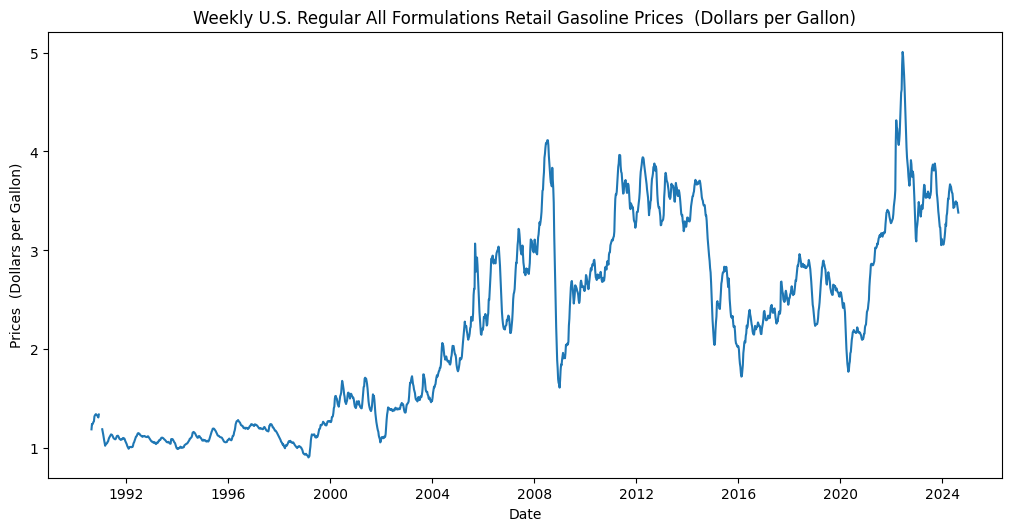

In [5]:
# plot the prices vs Dates
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)

plt.title('Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)')
plt.xlabel('Date')
plt.ylabel('Prices  (Dollars per Gallon)')

plt.plot(df_sorted['Date'],
         df_sorted['Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)'])

## Feature Engineering
Our data consistes of a univarite time series feature, to enhance the forecasting quality, a few transformations are proposed such as:
 - Log transformation of target variable (price).
 - Create signifiant number of lagged-target
 - Adding a rolling mean with the appropriate window.


In [6]:
# lags with log transformation
df_lags = data.copy()
df_lags.set_index('Date', inplace=True)

mod = ar_select_order(np.log(df_lags['Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)']),
                      trend='ct',
                      glob=True,
                      missing='drop',
                      # seasonal=True,
                      maxlag=12)

print('Significant log transformed price lags: ', mod.ar_lags)
del df_lags

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Significant log transformed price lags:  [1, 2, 4, 8]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [7]:
# formating data according to AutoGluon specs
data_ag = data.copy()
data_ag['item_id'] = 'Gas_Price'

data_ag.rename(columns={'Date':'timestamp',
                   'Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)':'target'},
          inplace=True)

data_ag['target'] = np.log(data_ag['target'])

# adding lagged cols
lags = mod.ar_lags
for lag in lags:
    data_ag['target_lag_' + str(lag)] = data_ag.target.shift(lag)

#  finding the best rolling mean
def find_best_window(data, window_range):
  best_window = None
  best_error = float('inf')

  for window in window_range:
    rolling_mean = data.rolling(window=window).mean()
    error = np.mean(abs(data - rolling_mean))
    if error < best_error:
      best_error = error
      best_window = window

  return best_window

best_window = find_best_window(data_ag['target'], range(53))
data_ag[f'rolling_mean_{best_window}'] = data_ag['target'].rolling(best_window).mean()

# deleting NaN values
data_ag.dropna(inplace=True)

data_ag.head()

,timestamp,target,item_id,target_lag_1,target_lag_2,target_lag_4,target_lag_8,rolling_mean_1
8,1990-10-15,0.291923,Gas_Price,0.287432,0.278389,0.235862,0.174793,0.291923
9,1990-10-22,0.296394,Gas_Price,0.291923,0.287432,0.240590,0.219136,0.296394
10,1990-10-29,0.291923,Gas_Price,0.296394,0.291923,0.278389,0.216723,0.291923
11,1990-11-05,0.288182,Gas_Price,0.291923,0.296394,0.287432,0.224742,0.288182
12,1990-11-12,0.283674,Gas_Price,0.288182,0.291923,0.291923,0.235862,0.283674


# Modeling

As advertised, Chronos is a language model-based architecture. It processes time series data by quantizing iy into buckets, which are treated as tokens similar to words in natural language. This tokenization allows Chronos to leverge the powerful techniques developed for language models to forecast time series data.

So, the goal is to bechmark Chronos to a handfull of models with different architectures.

## AutoGluon with minimal configuration

As mentionned in the introduction, we'll be using AutoGluon, an AutoML framework to train/test Pretrained (foundation) model Chronos against the following models:

**Baseline models**

 - 'SeasonalNaive',

**Statistical models**

 - 'AutoETS'
 - 'AutoARIMA'
 - 'NPTS'
 - 'CrostonSBA'
 - 'DynamicOptimizedTheta'

**Tabular models**

 - 'RecursiveTabular'
 - 'DirectTabular'

**Deep learning models**

 - 'TemporalFusionTransformer'
 - 'DeepAR'
 - 'PatchTST'


 All these models will be tested using AutoGluon, a python library that helps with automating the task of selecting, tuning and deploying machine learning models.

In [8]:
# preprocessed data
data_ag

,timestamp,target,item_id,target_lag_1,target_lag_2,target_lag_4,target_lag_8,rolling_mean_1
8,1990-10-15,0.291923,Gas_Price,0.287432,0.278389,0.235862,0.174793,0.291923
9,1990-10-22,0.296394,Gas_Price,0.291923,0.287432,0.240590,0.219136,0.296394
10,1990-10-29,0.291923,Gas_Price,0.296394,0.291923,0.278389,0.216723,0.291923
11,1990-11-05,0.288182,Gas_Price,0.291923,0.296394,0.287432,0.224742,0.288182
12,1990-11-12,0.283674,Gas_Price,0.288182,0.291923,0.291923,0.235862,0.283674
...,...,...,...,...,...,...,...,...
1770,2024-07-22,1.244443,Gas_Price,1.251619,1.249615,1.234890,1.274524,1.244443
1771,2024-07-29,1.248181,Gas_Price,1.244443,1.251619,1.246745,1.257324,1.248181
1772,2024-08-05,1.237794,Gas_Price,1.248181,1.244443,1.249615,1.232269,1.237794
1773,2024-08-12,1.227885,Gas_Price,1.237794,1.248181,1.251619,1.234017,1.227885


In [9]:
# loading training data
train_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[:-52],
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target  target_lag_1  target_lag_2  target_lag_4  \
item_id   timestamp                                                        
Gas_Price 1990-10-15  0.291923      0.287432      0.278389      0.235862   
          1990-10-22  0.296394      0.291923      0.287432      0.240590   
          1990-10-29  0.291923      0.296394      0.291923      0.278389   
          1990-11-05  0.288182      0.291923      0.296394      0.287432   
          1990-11-12  0.283674      0.288182      0.291923      0.291923   

                      target_lag_8  rolling_mean_1  
item_id   timestamp                                 
Gas_Price 1990-10-15      0.174793        0.291923  
          1990-10-22      0.219136        0.296394  
          1990-10-29      0.216723        0.291923  
          1990-11-05      0.224742        0.288182  
          1990-11-12      0.235862        0.283674

In [11]:
# training models with 'best_quality' as preset for a max duration of 10 minutes
predictor = TimeSeriesPredictor(
    freq='W-MON',
    prediction_length=52,
    path="us_gas",
    target="target",
    eval_metric="sMAPE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'us_gas'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   43.32 GB / 78.19 GB (55.4%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': SMAPE,
 'freq': 'W-MON',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 52,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'W-MON'.

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.1175       = Validation score (-SMAPE)
	18.95   s     = Training runtime
	3.23    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 171.6s of the 514.8s of remaining time.
	-0.0785       = Validation score (-SMAPE)
	121.75  s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 196.5s of the 393.0s of remaining time.
	-0.1150       = Validation score (-SMAPE)
	185.38  s     = Training runtime
	0.43    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 207.2s of the 207.2s of remaining time.
	-0.0666       = Validation score (-SMAPE)
	68.18   s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training complete. Models trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTra

In [13]:
# Model leaderboard
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.066561,0.041372,68.176389,12
1,TemporalFusionTransformer,-0.078468,0.027199,121.751875,10
2,RecursiveTabular,-0.080060,1.132880,11.482615,2
3,AutoARIMA,-0.102947,0.125420,13.963595,8
4,SeasonalNaive,-0.106031,0.020281,0.068240,1
5,AutoETS,-0.106031,0.067719,12.552337,7
6,DynamicOptimizedTheta,-0.106551,0.182195,17.945045,6
7,DeepAR,-0.115042,0.428900,185.383784,11
8,Chronos[base],-0.117530,3.227673,18.948594,9
9,CrostonSBA,-0.155768,0.015376,0.057520,4


data with frequency 'None' has been resampled to frequency 'W-MON'.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
Model not specified in predict, will default to the model with the best validation score: PatchTST


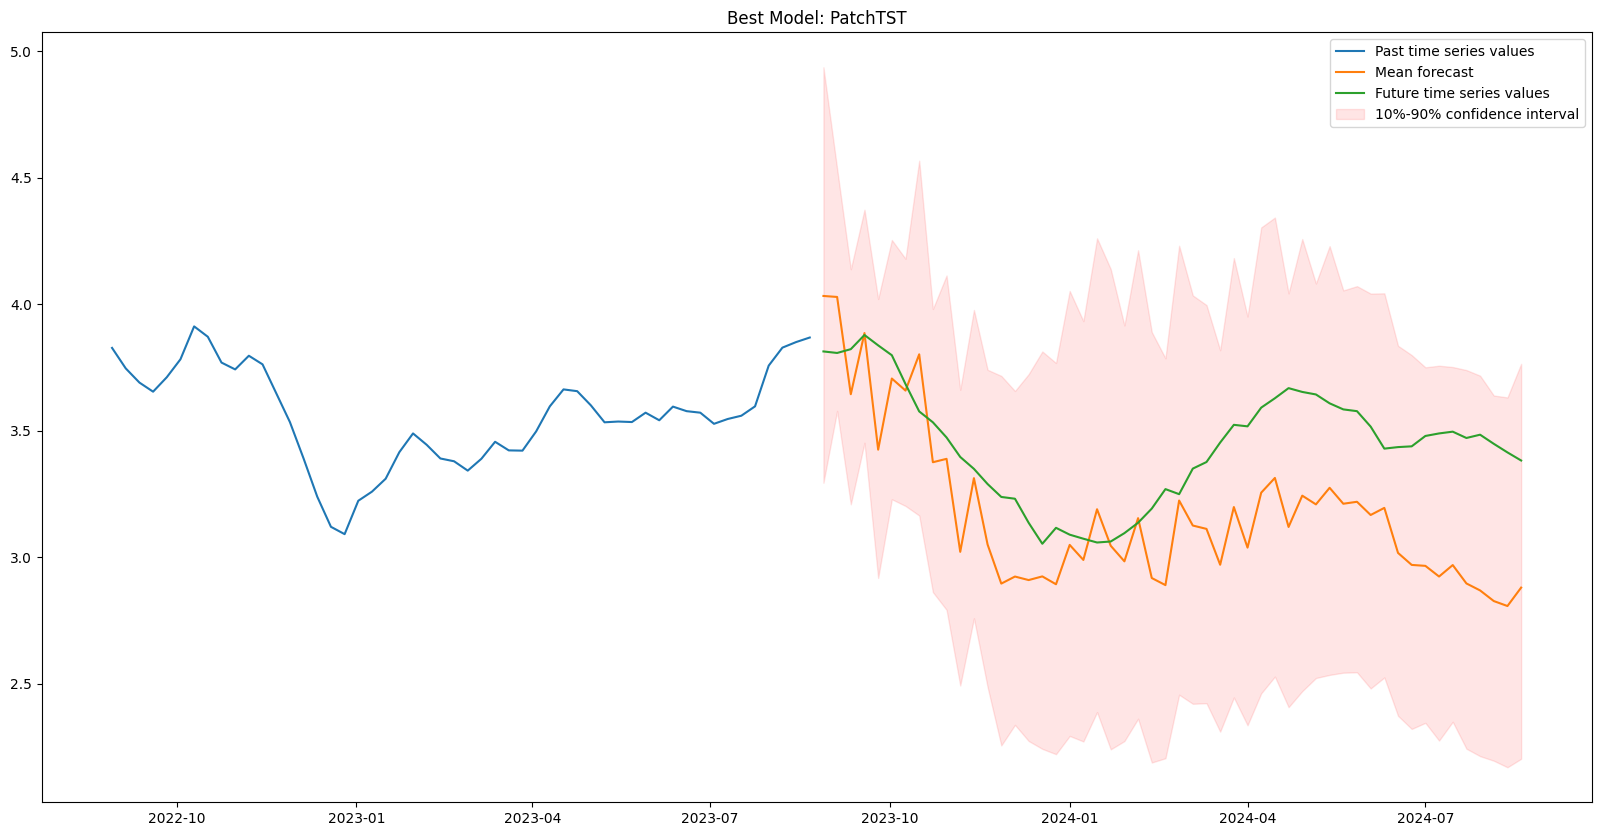

In [33]:
predictions = predictor.predict(train_data)

test_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[-52:],
    id_column="item_id",
    timestamp_column="timestamp"
)

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = np.exp(train_data.loc[item_id]["target"][-52:])
y_pred = np.exp(predictions.loc[item_id])
y_test = np.exp(test_data.loc[item_id]["target"])

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Best Model: PatchTST')
plt.legend();

data with frequency 'None' has been resampled to frequency 'W-MON'.
Model not specified in predict, will default to the model with the best validation score: PatchTST
data with frequency 'None' has been resampled to frequency 'W-MON'.


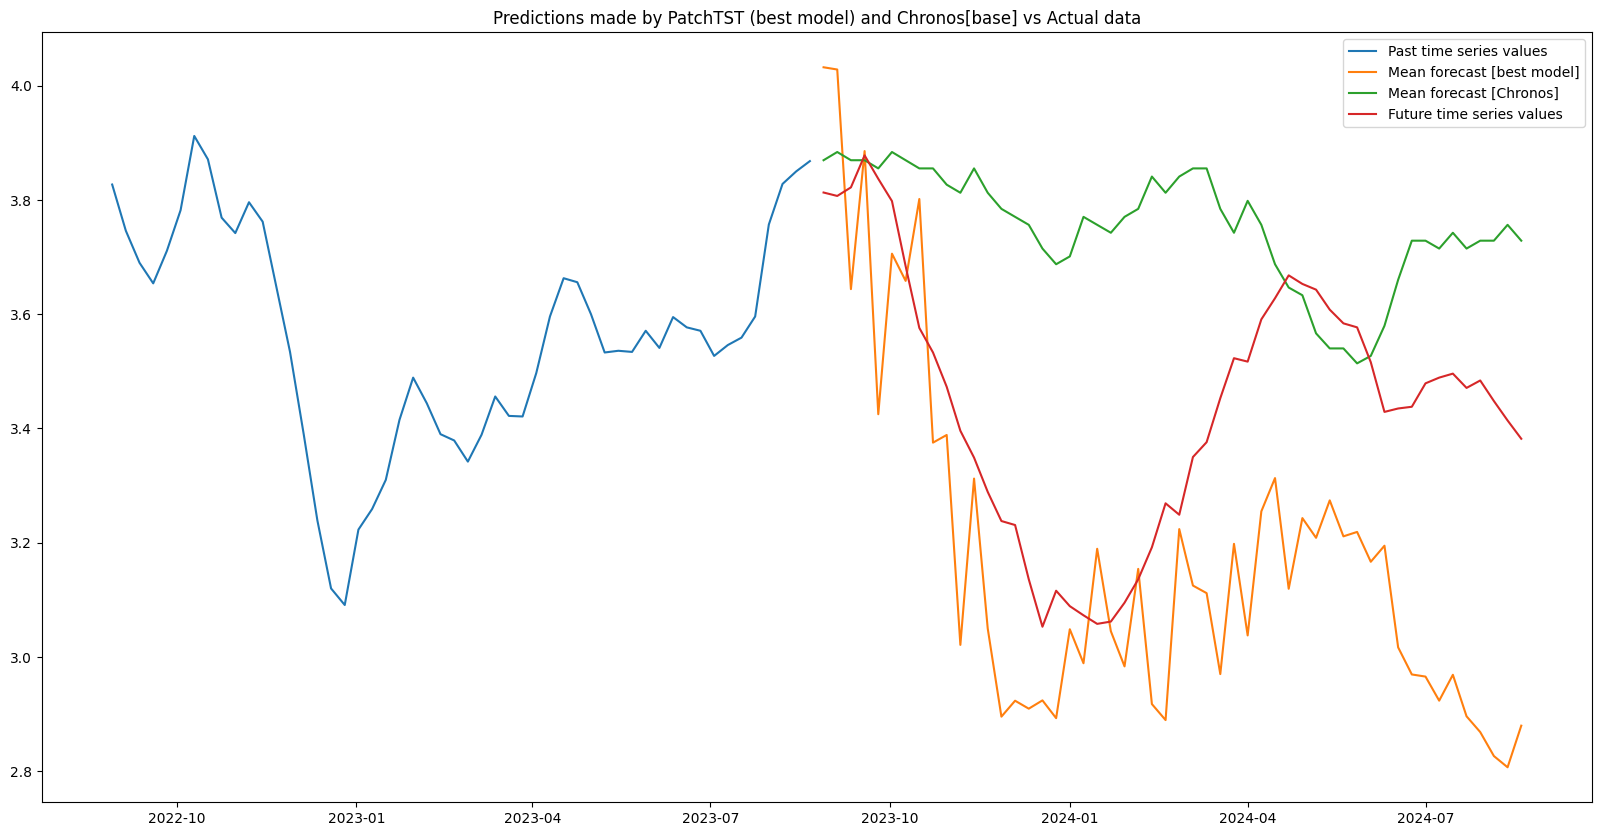

In [36]:
predictions_best = predictor.predict(train_data)
predictions_chronos = predictor.predict(train_data, model='Chronos[base]')


test_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[-52:],
    id_column="item_id",
    timestamp_column="timestamp"
)

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = np.exp(train_data.loc[item_id]["target"][-52:])
y_pred_best = np.exp(predictions_best.loc[item_id])
y_pred_chronos = np.exp(predictions_chronos.loc[item_id])
y_test = np.exp(test_data.loc[item_id]["target"])#[-52:]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred_best["mean"], label="Mean forecast [best model]")
plt.plot(y_pred_chronos["mean"], label="Mean forecast [Chronos]")
plt.plot(y_test, label="Future time series values")

plt.title('Predictions made by PatchTST (best model) and Chronos[base] vs Actual data')
plt.legend();

## AutoGluon with hyperparameters tuning
Let's select the best model (PatchTST) and a bigger variation of Chronos (Chronos[Large]), add more training time and activate hyperparameter tuning.


In [19]:
# data
data_ag.head()

,timestamp,target,item_id,target_lag_1,target_lag_2,target_lag_4,target_lag_8,rolling_mean_1
8,1990-10-15,0.291923,Gas_Price,0.287432,0.278389,0.235862,0.174793,0.291923
9,1990-10-22,0.296394,Gas_Price,0.291923,0.287432,0.240590,0.219136,0.296394
10,1990-10-29,0.291923,Gas_Price,0.296394,0.291923,0.278389,0.216723,0.291923
11,1990-11-05,0.288182,Gas_Price,0.291923,0.296394,0.287432,0.224742,0.288182
12,1990-11-12,0.283674,Gas_Price,0.288182,0.291923,0.291923,0.235862,0.283674


In [20]:
# training with hyperparam tuning activated
predictor_tuned = TimeSeriesPredictor(
    freq='W-MON',
    prediction_length=52,
    path="us_gas_tuned",
    target="target",
    eval_metric="sMAPE",
)

predictor_tuned.fit(
    data_ag[:-52],
    hyperparameters={
        "PatchTST": {
            "context_length" : ag.common.space.Int(5, 36),
            "patch_len": ag.common.space.Int(4, 32),
            "stride": ag.common.space.Int(4, 32),
            "d_model": ag.common.space.Int(4, 128),
            "nhead": ag.common.space.Int(2, 64),
            "dim_feedforward": ag.common.space.Int(2, 32),
            "dropout": ag.common.space.Categorical(0.1, 0.3),
            "lr": ag.common.space.Real(1e-5, 1e-2, log=True),
            "batch_size": ag.common.space.Int(8, 128),
        },

        "Chronos": {
            "model_path": "large",
            "batch_size": ag.common.space.Int(8, 128),
            "device": "auto",
        }
    },
    hyperparameter_tune_kwargs="auto",
    enable_ensemble=True,
    time_limit=1200,
)

Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'us_gas_tuned'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       9.03 GB / 12.67 GB (71.3%)
Disk Space Avail:   42.55 GB / 78.19 GB (54.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'freq': 'W-MON',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': {'batch_size': Int: lower=8, upper=128,
                                 'device': 'auto',
                                 'model_path': 'large'},
                     'PatchTST': {'batch_size': Int: lower=8, upper=128,
                                  'context_length': Int: lower=5, upper=36,
                                  'd_model': Int: lower=4, upper=128,
    

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	Trained 50 models while tuning Chronos[large].
	-0.0305       = Validation score (-SMAPE)
	392.73  s     = Total tuning time
Hyperparameter tuning model PatchTST. Tuning model for up to 403.2s of the 806.4s remaining.
	Trained 3 models while tuning PatchTST.
	-0.0416       = Validation score (-SMAPE)
	413.36  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[large]/T1': 0.34,
 'Chronos[large]/T21': 0.54,
 'Chronos[large]/T3': 0.04,
 'Chronos[large]/T30': 0.01,
 'Chronos[large]/T39': 0.01,
 'Chronos[large]/T50': 0.04,
 'PatchTST/2134198e': 0.01,
 'PatchTST/969f2bfd': 0.01}
	-0.0227       = Validation score (-SMAPE)
	7.66    s     = Training runtime
	65.36   s     = Validation (prediction) runtime
Training complete. Models trained: ['Chronos[large]/T1', 'Chronos[large]/T2', 'Chronos[large]/T3', 'Chronos[large]/T4', 'Chronos[large]/T5', 'Chronos[large]/T6', 'Chronos[large]/T7', 'Chronos[large]/T8', 'Chronos[large]/T9', 'Chronos[large]/T10', 'Chronos

In [25]:
# 20 best models
predictor_tuned.leaderboard().head(20)

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.022654,65.363794,7.655931,54
1,Chronos[large]/T21,-0.030460,7.092993,7.103326,21
2,Chronos[large]/T1,-0.034107,26.712101,26.723743,1
3,Chronos[large]/T39,-0.034840,7.218673,7.227651,39
4,Chronos[large]/T35,-0.035632,7.073022,7.084516,35
5,Chronos[large]/T10,-0.036857,7.046895,7.056109,10
6,Chronos[large]/T3,-0.037176,8.886821,8.900249,3
7,Chronos[large]/T46,-0.037676,7.178666,7.194136,46
8,Chronos[large]/T41,-0.037778,7.671214,7.680367,41
9,Chronos[large]/T50,-0.038211,8.090052,8.098771,50


data with frequency 'None' has been resampled to frequency 'W-MON'.
data with frequency 'None' has been resampled to frequency 'W-MON'.


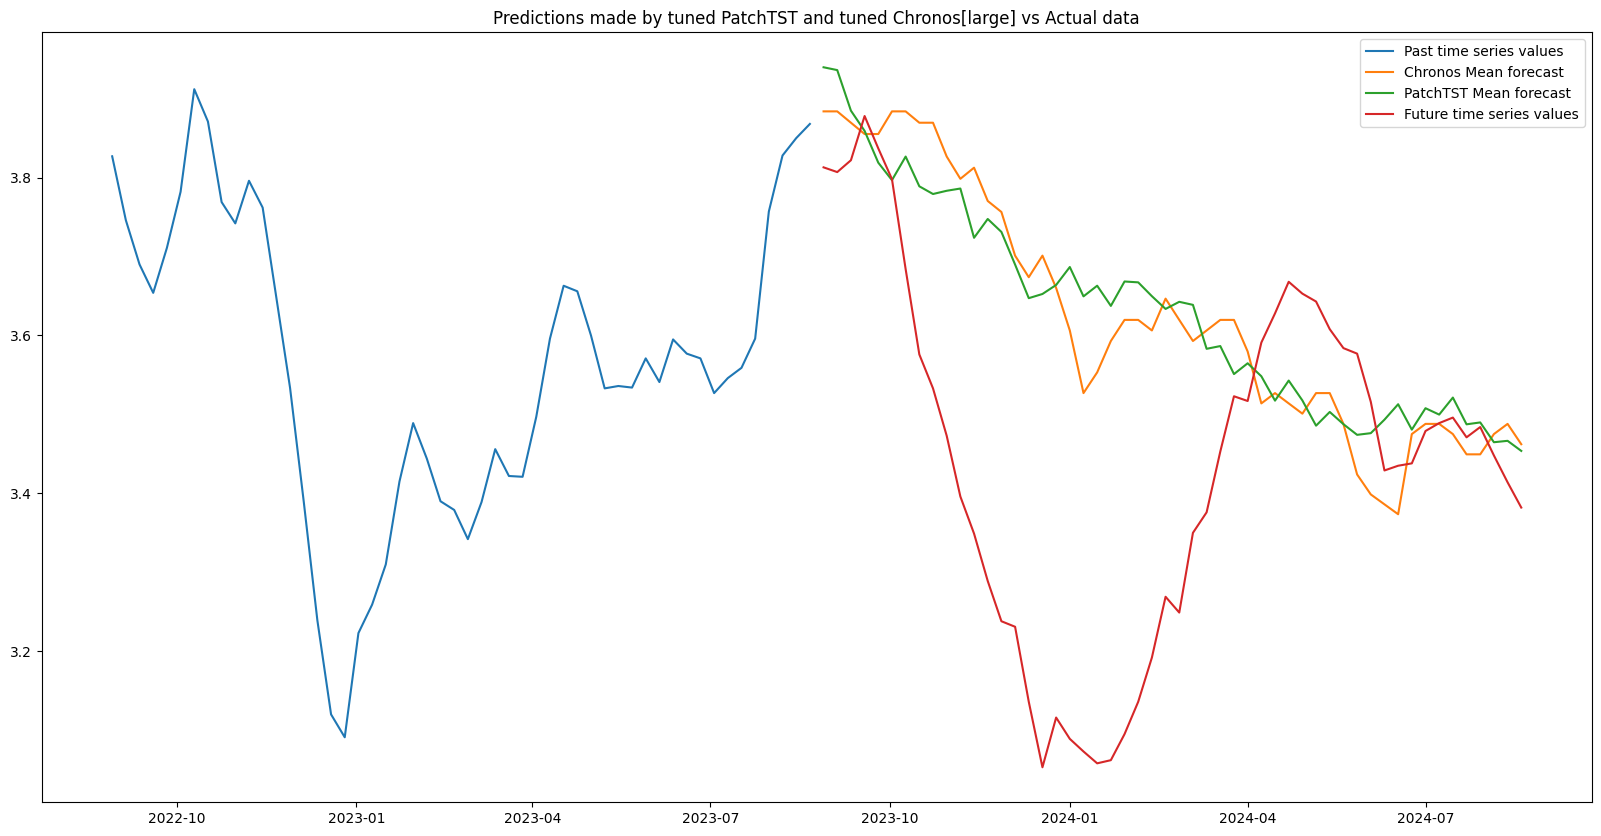

In [37]:
train_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[:-52],
    id_column="item_id",
    timestamp_column="timestamp"
)

test_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[-52:],
    id_column="item_id",
    timestamp_column="timestamp"
)

predictions_best_chronos = predictor_tuned.predict(train_data, model='Chronos[large]/T21')
predictions_best_PatchTST = predictor_tuned.predict(train_data, model='PatchTST/b475b036')


plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = np.exp(train_data.loc[item_id]["target"][-52:])
y_pred_chronos = np.exp(predictions_best_chronos.loc[item_id])
y_pred_PatchTST = np.exp(predictions_best_PatchTST.loc[item_id])
y_test = np.exp(test_data.loc[item_id]["target"])

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred_chronos["mean"], label="Chronos Mean forecast")
plt.plot(y_pred_PatchTST["mean"], label="PatchTST Mean forecast")
plt.plot(y_test, label="Future time series values")


plt.title('Predictions made by tuned PatchTST and tuned Chronos[large] vs Actual data')
plt.legend();

data with frequency 'None' has been resampled to frequency 'W-MON'.


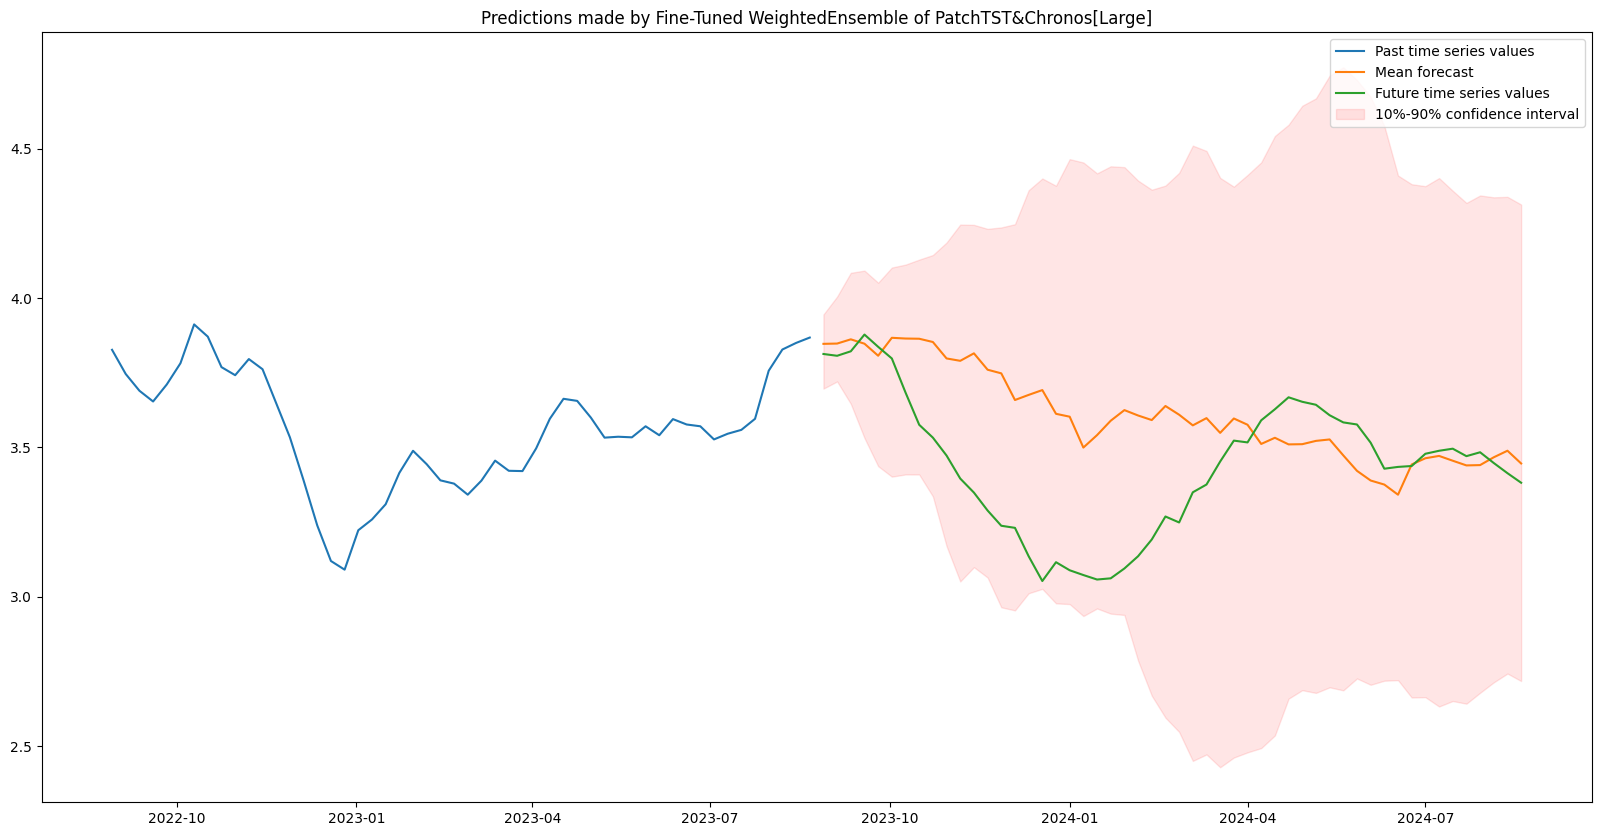

In [38]:
predictions_weightedEnsemble = predictor_tuned.predict(train_data, model='WeightedEnsemble')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = np.exp(train_data.loc[item_id]["target"][-52:])
y_pred = np.exp(predictions_weightedEnsemble.loc[item_id])
y_test = np.exp(test_data.loc[item_id]["target"])

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Predictions made by Fine-Tuned WeightedEnsemble of PatchTST&Chronos[Large]')
plt.legend();

In [ ]:
# getting around NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968
# import locale
# print(locale.getpreferredencoding())

# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [56]:
# saving model
!zip -r us_gas_tuned.zip "/content/us_gas_tuned"

updating: content/us_gas_tuned/ (stored 0%)
  adding: content/us_gas_tuned/models/ (stored 0%)
  adding: content/us_gas_tuned/models/trainer.pkl (deflated 75%)
  adding: content/us_gas_tuned/models/Chronos[large]/ (stored 0%)
  adding: content/us_gas_tuned/models/Chronos[large]/T26/ (stored 0%)
  adding: content/us_gas_tuned/models/Chronos[large]/T26/utils/ (stored 0%)
  adding: content/us_gas_tuned/models/Chronos[large]/T26/utils/oof.pkl (deflated 51%)
  adding: content/us_gas_tuned/models/Chronos[large]/T26/model.pkl (deflated 49%)
  adding: content/us_gas_tuned/models/Chronos[large]/T26/W0/ (stored 0%)
  adding: content/us_gas_tuned/models/Chronos[large]/T26/W0/model.pkl (deflated 47%)
  adding: content/us_gas_tuned/models/Chronos[large]/T49/ (stored 0%)
  adding: content/us_gas_tuned/models/Chronos[large]/T49/utils/ (stored 0%)
  adding: content/us_gas_tuned/models/Chronos[large]/T49/utils/oof.pkl (deflated 51%)
  adding: content/us_gas_tuned/models/Chronos[large]/T49/model.pkl (de

# Back to the future

Now, lets have a glimpse of future 52 weeks of US regular retail gasoline price

In [ ]:
# loading model
# !unzip '/content/us_gas_tuned.zip'
# predictor_tuned = TimeSeriesPredictor.load("us_gas_tuned")

data with frequency 'None' has been resampled to frequency 'W-MON'.


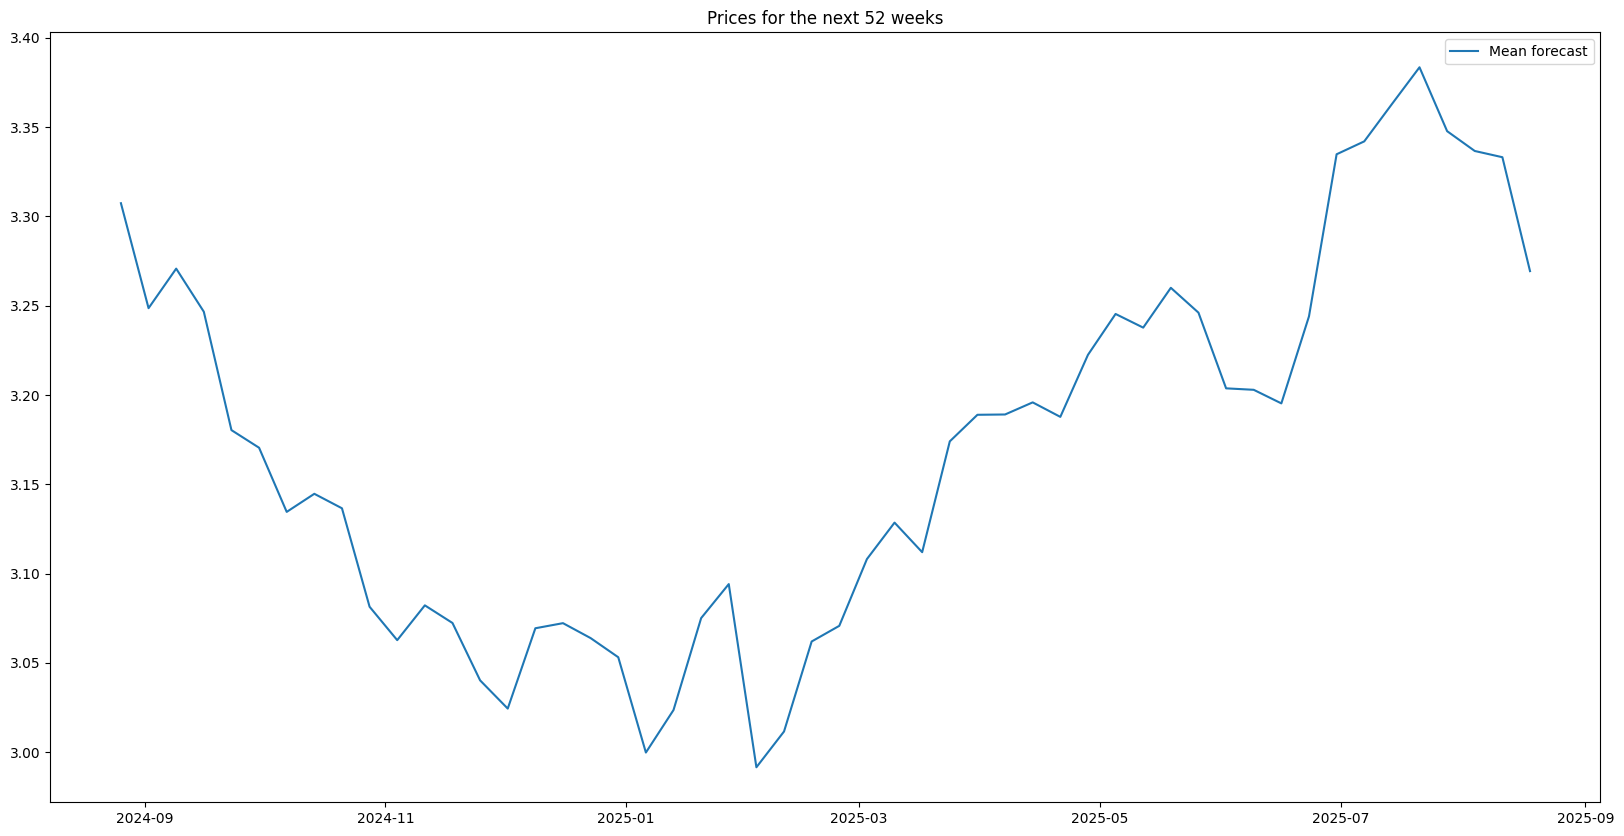

In [46]:
predictions_weightedEnsemble = predictor_tuned.predict(data_ag, model='WeightedEnsemble')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_pred = np.exp(predictions_weightedEnsemble.loc[item_id])

plt.plot(y_pred["mean"], label="Mean forecast")

# plt.fill_between(
#     y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
# )
plt.title('Prices for the next 52 weeks')
plt.legend();

# 12. REFERENCES

[Fuel Cost (Gasoline, Petrol) Travel Calculator](https://www.numbeo.com/gas-prices/in/Albany)

[US Gasoline and Diesel Fuel Update](https://www.eia.gov/petroleum/gasdiesel/)

[Chronos: Learning the Language of Time Series](https://github.com/amazon-science/chronos-forecasting)

[Adapting language model architectures for time series forecasting](https://www.amazon.science/blog/adapting-language-model-architectures-for-time-series-forecasting)

[Forecasting with AutoGluon](https://auto.gluon.ai/0.7.0/tutorials/timeseries/forecasting-indepth.html)
